# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** ARIMA - static and dynamic forecasts

</font>
</div>

# Import modules
<hr style = "border:2px solid black" ></hr>

In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

# Load data
<hr style = "border:2px solid black" ></hr>

In [3]:
data = sm.datasets.co2.load_pandas()
y = data.data

In [20]:
data

<class 'statsmodels.datasets.utils.Dataset'>

In [4]:
# The 'MS' string groups the data into buckets by the start of the month
y = y['co2'].resample('MS').mean()

# 'bfill' means that we use the value before filling in missing values
y = y.fillna(y.bfill())

y

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

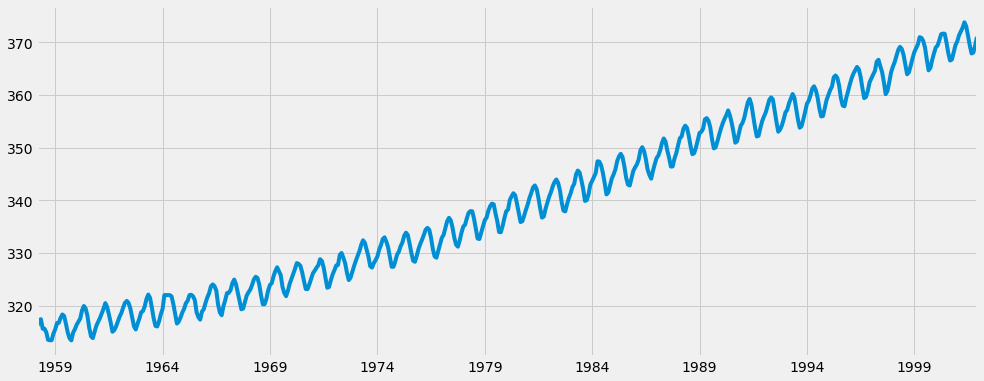

In [5]:
y.plot(figsize=(15, 6))
plt.show()

# Modelling: ARIMA hyperparameters
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- There are three distinct integers `p`, `d`, `q` that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation `ARIMA(p, d, q)`. Together these three parameters account for seasonality, trend, and noise in datasets.

    - `p` is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
    - `d` is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
    - `q` is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

- When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as `ARIMA(p,d,q)(P,D,Q)s`. Here, `p`, `d`, `q` are the non-seasonal parameters described above, while `P`, `D`, `Q` follow the same definition but are applied to the seasonal component of the time series. The term `s` is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

- We're using grid search to find the params.

</font>
</div>

In [6]:
# Define p, d, q params to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Generate all different combos of seasonal P, D, Q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [7]:
print('Examples of parameter combos for SARIMA:')
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combos for SARIMA:
SARIMA: (0, 0, 1) x (0, 0, 1, 12)
SARIMA: (0, 0, 1) x (0, 1, 0, 12)
SARIMA: (0, 1, 0) x (0, 1, 1, 12)
SARIMA: (0, 1, 0) x (1, 0, 0, 12)


The following grid search optimizes the params for best (lowest) [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion):

In [8]:
warnings.filterwarnings("ignore")

# The blog post doesn't separate the training and test sets.
# I'm doing that here. Everything up to 1997-12-31 is training.
#y_trunc = y[:'1997-12-31']

min_aic = float('inf')
min_params = None
min_params_seasonal = None
min_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
#                y_trunc,
                y,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic = results.aic
                min_params = param
                min_params_seasonal = param_seasonal
                min_model = results
            print('ARIMA{}x{}: aic={}'.format(param, param_seasonal, results.aic))
        except:
            continue

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.23439D+00    |proj g|=  7.60014D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   7.600D-07   7.234D+00
  F =   7.2343948953241553     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12): aic=7612.583429881011
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables a

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     20      1     0     0   1.234D+00   1.003D+00
  F =   1.0027936236996264     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 0, 0, 12): aic=1058.938892132007
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00474D+00    |proj g|=  1.83808D+01

At iterate    5    f=  1.00373D+00    |proj g|=  1.57826D+01

At iterate   10    f=  9.99143D-01    |proj g|=  2.79266D+00

At iterate   15  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.89320D-01    |proj g|=  2.28572D-01

At iterate   15    f=  9.87419D-01    |proj g|=  5.12848D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     24      1     0     0   5.128D-05   9.874D-01
  F =  0.98741900313659903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 1, 1, 12): aic=1044.7647912997022
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11368D+00    |proj g|=  6.58691D-01

At iterate    5 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.31524D+00    |proj g|=  7.14071D-01

At iterate    5    f=  6.64698D+00    |proj g|=  8.76741D-02

At iterate   10    f=  6.61982D+00    |proj g|=  2.62308D-03

At iterate   15    f=  6.61731D+00    |proj g|=  3.22173D-02

At iterate   20    f=  6.47288D+00    |proj g|=  4.38343D-01

At iterate   25    f=  5.82009D+00    |proj g|=  4.90895D-01

At iterate   30    f=  5.76764D+00    |proj g|=  2.68575D-01

At iterate   35    f=  5.76679D+00    |proj g|=  1.57928D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.30724D+00    |proj g|=  8.57565D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     10      1     0     0   9.496D-06   1.307D+00
  F =   1.3072187326395963     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 0, 12): aic=1379.1941067368552
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41353D+00    |proj g|=  3.92879D-01

At iterate    5    f=  1.17437D+00    |proj g|=  6.70009D-03

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.58167D+00    |proj g|=  1.31346D-02

At iterate   10    f=  6.57878D+00    |proj g|=  1.18976D-01

At iterate   15    f=  4.82292D+00    |proj g|=  8.02168D+01

At iterate   20    f=  2.42181D+00    |proj g|=  2.55892D+02

At iterate   25    f=  2.02312D+00    |proj g|=  1.22328D+02

At iterate   30    f=  1.39124D+00    |proj g|=  3.72254D+01

At iterate   35    f=  1.18481D+00    |proj g|=  6.61415D+00

At iterate   40    f=  1.10021D+00    |proj g|=  2.30866D+01

At iterate   45    f=  1.05197D+00    |proj g|=  2.30427D+00

At iterate   50    f=  1.03333D+00    |proj g|=  7.83424D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  6.52695D+00    |proj g|=  1.09206D-01

At iterate   20    f=  4.51774D+00    |proj g|=  1.34045D+01

At iterate   25    f=  2.01985D+00    |proj g|=  2.80094D+01

At iterate   30    f=  1.08991D+00    |proj g|=  6.04239D+01

At iterate   35    f=  8.86461D-01    |proj g|=  7.40997D+00

At iterate   40    f=  7.38834D-01    |proj g|=  3.73319D+01

At iterate   45    f=  7.34250D-01    |proj g|=  9.17044D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45    111      1     0     0   9.170D-02   7.343D-01
  F =  0.73425013464705857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   2.923D-06   1.059D+00
  F =   1.0585511305685982     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 0, 12): aic=1119.5957893581653
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38037D+00    |proj g|=  8.40437D-01

At iterate    5    f=  8.24064D-01    |proj g|=  2.82783D-01

At iterate   10    f=  7.62255D-01    |proj g|=  1.26741D-01

At iterate   15 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.17512D+00    |proj g|=  2.31003D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     13      1     0     0   8.932D-06   1.175D+00
  F =   1.1751151330032374     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 0, 1, 12): aic=1240.2211199194057
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.00406D-01    |proj g|=  5.95692D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of f

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.52599D-01    |proj g|=  5.38848D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     21      1     0     0   6.861D-05   3.526D-01
  F =  0.35259351332274452     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 0, 1, 12): aic=376.92837601552725
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50884D-01    |proj g|=  4.96079D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of f

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.19123D-01    |proj g|=  5.41952D-01

At iterate   10    f=  3.03923D-01    |proj g|=  5.64370D-03

At iterate   15    f=  3.01639D-01    |proj g|=  1.07798D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     46      1     0     0   1.078D-02   3.016D-01
  F =  0.30163936699706095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 1, 12): aic=323.32461408090813
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.04172D+00    |proj g|=  1.23976D-02

At iterate   10    f=  1.04167D+00    |proj g|=  1.98936D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   1.989D-06   1.042D+00
  F =   1.0416740241732294     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 0, 1, 12): aic=1101.8410734302374
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.56081D-01    |proj g|=  8.47704D-02

At iterate    5 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.85304D-01    |proj g|=  3.64837D-01

At iterate   10    f=  2.81840D-01    |proj g|=  1.41906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     19      1     0     0   4.234D-05   2.818D-01
  F =  0.28183925863986170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 1, 12): aic=302.4949000891345
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37809D+00    |proj g|=  2.28191D+00


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.52205D-01    |proj g|=  1.10078D-01

At iterate   10    f=  5.49842D-01    |proj g|=  6.63646D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     18      1     0     0   6.636D-06   5.498D-01
  F =  0.54984159063715154     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 0, 0, 12): aic=584.4333533502834
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24872D+00    |proj g|=  2.24405D+00

At iterate    5  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.05976D-01    |proj g|=  1.27914D-03

At iterate   10    f=  4.05976D-01    |proj g|=  1.02937D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     16      1     0     0   1.029D-06   4.060D-01
  F =  0.40597562814608706     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 0, 12): aic=433.0863608096836
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53731D-01    |proj g|=  8.34383D-01

At iterate    5  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  2.59999D-01    |proj g|=  6.30217D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     87      2     1     0   6.302D-03   2.600D-01
  F =  0.25999904924435324     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 1, 12): aic=281.5189998050596
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59020D+00    |proj g|=  4.07098D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of fu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.37228D+00    |proj g|=  4.51979D-01

At iterate   15    f=  1.36672D+00    |proj g|=  6.68041D+00

At iterate   20    f=  1.17598D+00    |proj g|=  4.51599D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     61      1     0     0   3.224D-02   1.175D+00
  F =   1.1748434587998571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 0, 0)x(0, 0, 1, 12): aic=1241.9353186574497
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89601D-01    |proj g|=  4.70551D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      7      1     0     0   6.029D-05   5.896D-01
  F =  0.58960098395795280     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 1, 0, 12): aic=624.2602351237664
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 0, 0)x(1, 0, 0, 12): aic=579.3895835631893
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12698D+00    |proj g|=  7.17839D-01

At iterate    5    f=  5.00405D-01    |proj g|=  4.01812D-01

At iterate   10    f=  4.60113D-01    |proj g|=  9.31947D+00

At iterate   15    f=  4.35483D-01    |proj g|=  1.22244D+00

At iterate   20    f=  4.31261D-01    |proj g|=  1.35338D+00

At iterate   25    f=  3.59239D-01    |proj g|=  1.04200D+00

At iterate   30    f=  3.44808D-01    |proj g|=  2.81728D+00

At iterate   35    f=  3.44670D-01    |proj g|=  4.89643D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04621D-01    |proj g|=  4.54005D-01

At iterate    5    f=  4.39848D-01    |proj g|=  1.23676D+00


 This problem is unconstrained.



At iterate   10    f=  3.12726D-01    |proj g|=  6.43440D-01

At iterate   15    f=  3.05708D-01    |proj g|=  4.66420D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     30      1     0     0   1.261D-05   3.057D-01
  F =  0.30568868747156802     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 1, 1, 12): aic=329.5844992200896
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74496D+00    |proj g|=  6.05778D+01

At iterate    5  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.31900D+00    |proj g|=  3.39753D+01

At iterate   20    f=  1.29950D+00    |proj g|=  4.04779D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     42      1     0     0   6.888D-02   1.299D+00
  F =   1.2990575933159905     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 0, 12): aic=1372.6085881684219
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24590D+00    |proj g|=  1.24549D+00

At iterate    5 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.05800D-01    |proj g|=  1.26899D+00

At iterate   10    f=  2.83072D-01    |proj g|=  1.00688D-01

At iterate   15    f=  2.82957D-01    |proj g|=  8.67014D-02

At iterate   20    f=  2.82916D-01    |proj g|=  1.16175D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   1.543D-04   2.829D-01
  F =  0.28291576328602719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 1, 1, 12): aic=305.6273829769006
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0   

 This problem is unconstrained.



At iterate   20    f=  5.76587D-01    |proj g|=  6.31369D+00

At iterate   25    f=  5.74753D-01    |proj g|=  2.20681D-01

At iterate   30    f=  5.73963D-01    |proj g|=  7.27908D+00

At iterate   35    f=  5.61820D-01    |proj g|=  4.13299D+00

At iterate   40    f=  5.56461D-01    |proj g|=  5.57009D+00

At iterate   45    f=  5.52537D-01    |proj g|=  2.97581D+00

At iterate   50    f=  5.50546D-01    |proj g|=  1.79181D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     70      1     0     0   1.792D+00   5.505D-01
  F =  0.55054555525615534     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  1.16988D+00    |proj g|=  1.04413D+00

At iterate   10    f=  8.69968D-01    |proj g|=  4.72589D+00

At iterate   15    f=  5.59102D-01    |proj g|=  3.48983D+01

At iterate   20    f=  4.97034D-01    |proj g|=  1.40905D+01

At iterate   25    f=  4.30757D-01    |proj g|=  1.68249D+01

At iterate   30    f=  3.76575D-01    |proj g|=  6.30268D+00

At iterate   35    f=  3.72571D-01    |proj g|=  7.04430D+00

At iterate   40    f=  3.71747D-01    |proj g|=  5.93456D-02

At iterate   45    f=  3.70984D-01    |proj g|=  4.99786D+00

At iterate   50    f=  3.62156D-01    |proj g|=  9.42832D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.84921D-01    |proj g|=  1.58178D+00

At iterate   10    f=  4.09387D-01    |proj g|=  8.36516D-02

At iterate   15    f=  4.04513D-01    |proj g|=  2.29921D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   2.697D-05   4.045D-01
  F =  0.40451230651829340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 0, 12): aic=433.54694645724464
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  4.23350D-01    |proj g|=  1.40149D+00

At iterate   10    f=  2.69705D-01    |proj g|=  2.52036D-01

At iterate   15    f=  2.62233D-01    |proj g|=  1.28620D-02

At iterate   20    f=  2.62184D-01    |proj g|=  1.43711D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  2.62134D-01    |proj g|=  2.39702D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     73      2     0     0   2.397D-03   2.621D-01
  F =  0.26213419251185732     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 1, 12): aic=285.7651705224739
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25505D+00    |proj g|=  1.51277D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of fu

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  2.91949D-01    |proj g|=  1.46853D-01

At iterate   10    f=  2.91003D-01    |proj g|=  2.81110D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     59      2     0     0   8.588D-05   2.910D-01
  F =  0.29100091571647974     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0)x(0, 1, 1, 12): aic=312.13296333373665
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73905D-01    |proj g|=  5.91870D-01

At iterate    5    f=  5.75628D-01    |proj g|=  3.63884D-01

At iterate   10    f=  5.58616D-01    |proj g|=  3.93378D-05

           * * *

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.59749D-01    |proj g|=  7.47555D-01

At iterate   10    f=  3.25635D-01    |proj g|=  1.86130D-01

At iterate   15    f=  3.24350D-01    |proj g|=  1.52122D-02

At iterate   20    f=  3.24343D-01    |proj g|=  1.40595D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     40      1     0     0   1.406D-04   3.243D-01
  F =  0.32434329444230975     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 0, 1, 12): aic=349.2091457533099
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.88784D-01    |proj g|=  2.03587D-01

At iterate   10    f=  2.71849D-01    |proj g|=  6.64751D-02

At iterate   15    f=  2.71623D-01    |proj g|=  3.01852D-03

At iterate   20    f=  2.71618D-01    |proj g|=  5.74959D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     39      1     0     0   5.750D-05   2.716D-01
  F =  0.27161846227609188     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 1, 12): aic=293.7426223144487
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.92456D-01    |proj g|=  1.12933D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   3.416D-07   9.925D-01
  F =  0.99245596236294864     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 1, 12): aic=1052.063672405822
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.47111D-01    |proj g|=  6.20435D-02

At iterate    5    f=  5.46873D-01    |proj g|=  1.37354D-04

           * * *


 This problem is unconstrained.



At iterate    5    f=  2.77558D-01    |proj g|=  3.74669D-01

At iterate   10    f=  2.73914D-01    |proj g|=  9.28261D-03

At iterate   15    f=  2.73705D-01    |proj g|=  1.67373D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   1.868D-05   2.737D-01
  F =  0.27370475869291250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 1, 12): aic=295.93740614494396
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.40898D-01    |proj g|=  4.28547D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   1.829D-05   5.407D-01
  F =  0.54074592314525494     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 0, 12): aic=576.8647111488082
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34434D-01    |proj g|=  6.56452D-01

At iterate    5    f=  4.38301D-01    |proj g|=  9.96486D-01

At iterate   10  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49067D-01    |proj g|=  8.40987D-01

At iterate    5    f=  2.76116D-01    |proj g|=  4.65682D-01

At iterate   10    f=  2.57264D-01    |proj g|=  2.41830D-02

At iterate   15    f=  2.54552D-01    |proj g|=  3.10521D-03

At iterate   20    f=  2.54546D-01    |proj g|=  2.95416D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     48      1     0     0   2.049D-03   2.545D-01
  F =  0.25454416872469338     

CONVERG

In [9]:
print('min_aic={}, min_params={}, min_params_seasonal={}'.format(min_aic, min_params, min_params_seasonal))

min_aic=277.78046549837745, min_params=(1, 1, 1), min_params_seasonal=(1, 1, 1, 12)


# Model diagnostic
<hr style = "border:2px solid black" ></hr>

We kept the best model from the HPO, so now we can explore it.

In [10]:
results = min_model # To align with the blog post
results.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

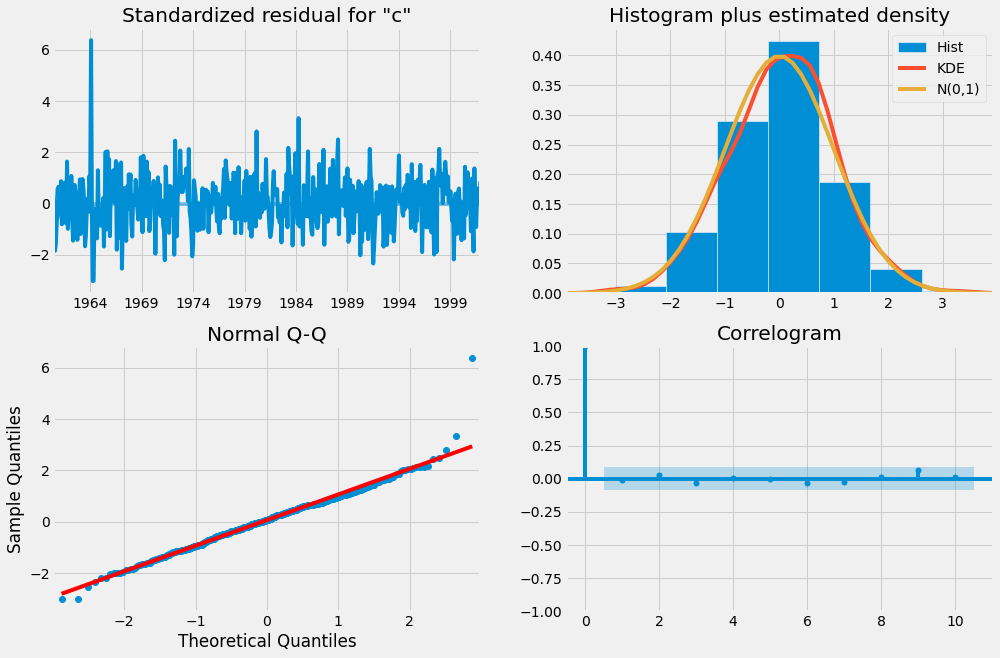

In [11]:
# KDE = kernel density estimate
# Q-Q plot = quantile/quantile
results.plot_diagnostics(figsize=(15, 10))
plt.show()

References:

- [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation)
- [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)

# Inference
<hr style = "border:2px solid black" ></hr>

## Static forecasts

In [12]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

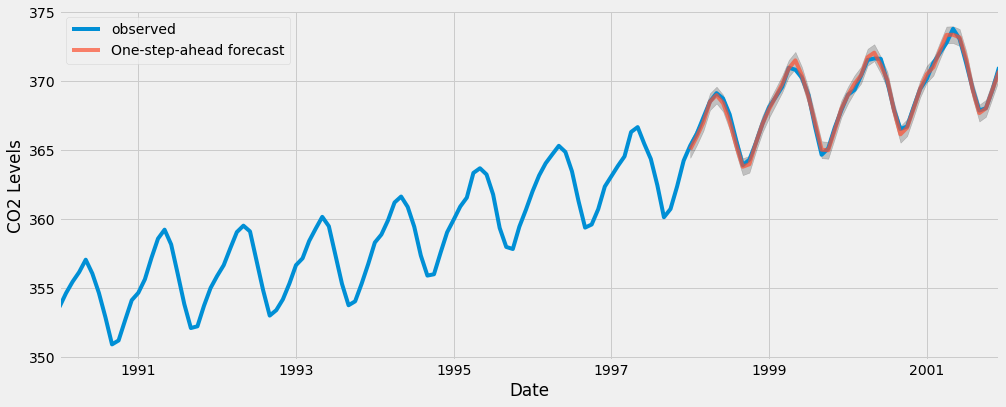

In [13]:
ax = y['1990':].plot(label='observed', figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='One-step-ahead forecast', alpha=0.7)

ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='k',
    alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [14]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


## Dynamic forecasts

In [15]:
pred_dynamic = results.get_prediction(start=pd.to_datetime(
    '1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

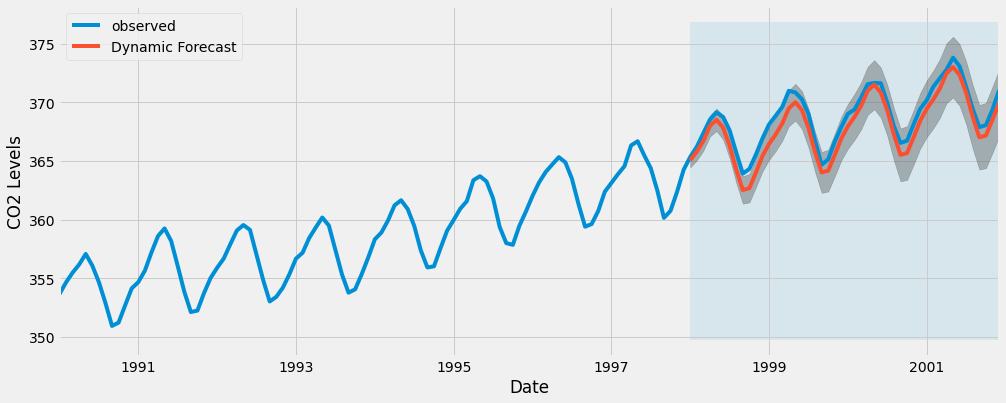

In [16]:
ax = y['1990':].plot(label='observed', figsize=(15, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(
    pred_dynamic_ci.index,
    pred_dynamic_ci.iloc[:, 0],
    pred_dynamic_ci.iloc[:, 1],
    color='k',
    alpha=.25)

ax.fill_betweenx(
    ax.get_ylim(),
    pd.to_datetime('1998-01-01'),
    y.index[-1],
    alpha=.1,
    zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [17]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


# How to get the prediction intervals
<hr style = "border:2px solid black" ></hr>

In [18]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(15, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- [GitHub Code](https://github.com/williewheeler/time-series-demos/blob/master/arima/arima-python.ipynb)
- [A Guide to Time Series Forecasting with ARIMA in Python 3](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)

</font>
</div>